# **Import Librairies**

In [ ]:
!!pip install -q MOABB

In [ ]:
!pip install pywd

In [5]:
import datetime as dt
import glob
import os
import zipfile

In [6]:
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.signal
import scipy.io as sio
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
import math


from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import svm
from keras.models import load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [7]:
import mne
from mne.channels import make_standard_montage
from mne.filter import construct_iir_filter

import moabb
from pywt import wavedec
from moabb.datasets import EPFLP300, utils
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.pipelines.features import LogVariance
from moabb.datasets import download as dl
from moabb.datasets.base import BaseDataset

moabb.set_log_level("info")

Tensorflow not install, you could not use those pipelines
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


In [8]:
import keras
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GRU, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Starting clean**

In [10]:
class Normalize:
    def __init__(self):
        self.min = []    # minimal amplitude for all EEG channels
        self.max = []    # maximal amplitude for all EEG channels
        self.mean = []   # mean amplitude for all EEG channels
        self.std = []    # standard deviation for all EEG channels
        self.method = '' # normalization method "minmax" or "z-score"

    def apply(self,n, x):
        # normalization procedure for EEG data
        # uses minima and maxima or means and standard deviations stored in
        # the object n

        n_channels, n_samples, n_trials = x.shape
        x = x.reshape(n_channels, n_samples * n_trials)

        if n.method == 'minmax':
            x = x - np.tile(n.min, (n_samples * n_trials, 1)).T
            x = x / np.tile(n.max - n.min, (n_samples * n_trials, 1)).T
            x = 2 * x - np.ones((n_channels, n_samples * n_trials))

        elif n.method == 'z-score':
            x = x - np.tile(n.mean, (n_samples * n_trials, 1)).T
            x = x / np.tile(n.std, (n_samples * n_trials, 1)).T

        else:
            print('unknown normalization method')

        x = x.reshape(n_channels, n_samples, n_trials)
        return x
    def train(self,n, x, method):
        """
        training procedure for normalize
        computes minima and maxima, or means and standard deviations for
        normalization of EEG channels

        INPUT:
            n       - object of type normalize
            x       - m*n*t matrix containing t EEG trials with m channels and
                      n samples
            method  - either 'minmax' or 'z-score'

        OUTPUT:
            n       - updated object of type normalize
        """
        n_channels = x.shape[0]
        n_samples = x.shape[1]
        n_trials = x.shape[2]
        x = x.reshape(n_channels, n_samples * n_trials)

        if method == 'minmax':
            n.min = np.min(x, axis=1)
            n.max = np.max(x, axis=1)
            n.method = 'minmax'
        elif method == 'z-score':
            n.mean = np.mean(x, axis=1)
            n.std = np.std(x, axis=1)
            n.method = 'z-score'
        else:
            print('unknown normalization method')

        return n

In [11]:
class windsor:
    def __init__(self):
        # constructor for class windsor
        # windsor can be used to "windsorize" EEG data

        # METHODS:
        #       train - computes percentiles of EEG channels
        #       apply - clips samples with amplitudes smaller or bigger than
        #               previously computed percentiles

        # Author: Ulrich Hoffmann - EPFL, 2006

        self.limit_l = []  # (lower) percentiles for each EEG channel
        self.limit_h = []  # (upper) percentiles for each EEG channel

    def apply(self, w, x):
        # windsorizes the data in x
        # this means that values that are smaller or bigger than the percentile
        # values in w.limit_l and w.limit_h are clipped

        # INPUT:
        #    w       - object of type windsor
        #    x       - m*n*t matrix containing t EEG trials with m channels and
        #              n samples

        # OUTPUT:
        #    x       - x windsorized

        # Author: Ulrich Hoffmann - EPFL, 2006

        ## initialize variables
        n_channels = x.shape[0]
        n_samples = x.shape[1]
        n_trials = x.shape[2]

        ## clip the data
        x = x.reshape(n_channels, n_samples * n_trials)
        w.limit_l=np.array(w.limit_l)
        w.limit_h=np.array(w.limit_h)
        l = np.tile(w.limit_l.reshape(-1, 1), (1, n_samples * n_trials))
        h = np.tile(w.limit_h.reshape(-1, 1), (1, n_samples * n_trials))
        i_l = x < l
        i_h = x > h
        x[i_l] = l[i_l]
        x[i_h] = h[i_h]
        x = x.reshape(n_channels, n_samples, n_trials)

        return x

    def train(self, w, x, p):
        # computes percentiles for windsorizing

        # INPUT:
        #    w       - object of type windsor
        #    x       - m*n*t matrix containing t EEG trials with m channels and
        #              n samples
        #    p       - percentage of samples that will be clipped from each channel

        # OUTPUT:
        #    w       - updated object of type windsor

        # Author: Ulrich Hoffmann - EPFL, 2006

        ## initialize variables
        n_channels = x.shape[0]
        n_samples  = x.shape[1]
        n_trials   = x.shape[2]
        n_clip     = round(n_samples*n_trials*p/2)
        x = np.reshape(x, (n_channels, n_samples*n_trials))
        w.limit_l = []
        w.limit_h = []

        ## compute (p/2)th percentiles for each channel
        for i in range(n_channels):
            tmp = np.sort(x[i,:])
            w.limit_l.append(tmp[n_clip])
            w.limit_h.append(tmp[-n_clip+1])

        return w

# **Preprocess Single Subject Data**

In [12]:
filename ='/content/drive/MyDrive/MNE/MNE-epflp300-data/groups/m/mm/mmspg/www/BCI/p300/subject9/session1/eeg_200308270304_epochs.mat'

f =scipy.io.loadmat(filename)
f['events'].shape[0]

126

In [ ]:
n_targets = 0  # keeps track of number of target trials
n_nontargets = 0  # keeps track of nontarget trials

# initialize variables
srate = 2048  # sampling rate of raw data in Hz
reference = [6, 23]  # indices of channels used as reference
filterorder = 3
filtercutoff = [1/1024, 12/1024]
f_b, f_a = scipy.signal.butter(filterorder, filtercutoff ,btype='bandpass')
decimation = 64  # downsampling factor
n_samples = 32  # number of (temporal) samples in a trial
sessions=[]  # main array of sessions for single subject (len = 4)

indir='/content/drive/MyDrive/MNE/MNE-epflp300-data/groups/m/mm/mmspg/www/BCI/p300/subject9'

for session in os.listdir(indir):
  runs = [None] * 6
  i=0
  sessiondir=os.path.join(indir, session)
  for filename in os.listdir(sessiondir):
      if not os.path.isdir(os.path.join(sessiondir, filename)):
          filename = os.path.join(sessiondir, filename)
          f =scipy.io.loadmat(filename)

          signals = f["data"]
          stimuli = f["stimuli"].squeeze()
          events = f["events"]
          target = f["target"][0][0]

          # 1. The last X entries are 0 for all signals. This leads to
          # artifacts when epoching and band-pass filtering the data.
          # We correct the signals for this.
          sig_i = np.where(np.diff(np.all(signals == 0, axis=0).astype(int)) != 0)[0][0]
          signals = signals[:, :sig_i]

          # 2. Rereference the data
          n_channels = f['data'].shape[0]
          ref = np.tile(np.mean(f['data'][reference, :], axis=0), (n_channels, 1))
          f['data'] = f['data'] - ref

          # 3. drop the mastoid channels
          f['data'] = f['data'][[1, 2, 3, 5, 6, 10, 14, 16, 19, 23, 24, 26, 27, 28], :]
          n_channels = f['data'].shape[0]

          # 4. Bandpass filter the data (with a forward-backward filter)
          for j in range(n_channels):
              f['data'][j, :] = filtfilt(f_b, f_a, f['data'][j, :])

          # 5. Downsample the data (from 2048 Hz to 64 Hz)
          f['data'] = f['data'][:, 0::decimation]

          n_trials = f['events'].shape[0]
          runs[i]={'x': np.zeros((n_channels, n_samples, n_trials)),
                        'y': np.zeros(n_trials),
                        'stimuli': stimuli,
                        'target': target}

          # getting the event time in a Python standardized way
          events_datetime = []
          for eventi in events:
              events_datetime.append(dt.datetime(*eventi.astype(int), int(eventi[-1] * 1e3) % 1000 * 1000))

          # Get the indices of the stimuli
          pos = []
          n_trials = len(stimuli)
          for j in range(n_trials):
              delta_seconds = (events_datetime[j] - events_datetime[0]).total_seconds()
              delta_indices = int(delta_seconds * srate/decimation)
              # has to add an offset
              pos.append(delta_indices + int(0.4 * srate/decimation))

          # 6. Extract trials (segmentation)
          # put everything in the cell-array runs
          # compute class labels
          for j in range(n_trials):
              runs[i]['x'][:, :, j] = f['data'][:, pos[j]:pos[j]+n_samples]
          runs[i]['y'][stimuli == target] = 1
          runs[i]['y'][stimuli != target] = -1

          # 7. Windsorizing
          xt=runs[i]['x']
          w = windsor()
          w= w.train(w,xt,0.1)
          x = w.apply(w,xt)

          # 8. Normalization using Z-score
          n= Normalize()
          n= n.train(n,x,'z-score')
          x= n.apply(n,x)
          runs[i]['x']=x

          # update counters
          n_targets += np.sum(runs[i]['y'] == 1)
          n_nontargets += np.sum(runs[i]['y'] == -1)
      i=i+1
  sessions.append(runs)

print(f'total target trials: {n_targets}')
print(f'total nontarget trials: {n_nontargets}')

total target trials: 551
total nontarget trials: 2755


In [ ]:
sessions[0][0]['x']

(14, 32, 126)

### **Prepare data to be 2D array (n_channels, n_samples) (32,32) array and outputs to be 0 and 1**

In [ ]:
def Preprocess_KF(sessions):
  X=[]
  Y=[]

  for session in range(4):
    for run in range(6):
      n_trials=sessions[session][run]['x'].shape[2]
      for trial in range(n_trials):
        X.append(sessions[session][run]['x'][:,:,trial])
        if(sessions[session][run]['y'][trial]==1):
          Y.append(1)
        else:
          Y.append(0)

  return X,Y

In [ ]:
X, Y = Preprocess_KF(sessions)

In [ ]:
x = np.array(X).astype(np.float64)
y = np.array(Y).astype(int)

In [ ]:
np.save('/content/drive/MyDrive/Emotiv/Sub 9/X.npy', x)
np.save('/content/drive/MyDrive/Emotiv/Sub 9/Y.npy', y)

### **Split Dataset**

In [ ]:
def Preprocess(sessions):
  x_train=[]
  y_train=[]

  for session in range(3):
    for run in range(6):
      n_trials=sessions[session][run]['x'].shape[2]
      for trial in range(n_trials):
        x_train.append(sessions[session][run]['x'][:,:,trial])
        if(sessions[session][run]['y'][trial]==1):
          y_train.append(1)
        else:
           y_train.append(0)

  x_test =[]
  y_test =[]
  for run in range(6):
      n_trials=sessions[3][run]['x'].shape[2]
      for trial in range(n_trials):
        x_test.append(sessions[3][run]['x'][:,:,trial])
        if(sessions[3][run]['y'][trial]==1):
          y_test.append(1)
        else:
          y_test.append(0)
  return x_train,y_train, x_test ,y_test

In [ ]:
x_train,y_train, x_test ,y_test=Preprocess(sessions)

In [ ]:
x_train = np.array(x_train).astype(np.float64)
y_train = np.array(y_train).astype(int)

x_test = np.array(x_test).astype(np.float64)
y_test = np.array(y_test).astype(int)

In [ ]:
np.save('/content/drive/MyDrive/Pre-processed Dataset/Sub 8/x_train.npy', x_train)
np.save('/content/drive/MyDrive/Pre-processed Dataset/Sub 8/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Pre-processed Dataset/Sub 8/x_test.npy', x_test)
np.save('/content/drive/MyDrive/Pre-processed Dataset/Sub 8/y_test.npy', y_test)

### **Classification Metric**

In [ ]:
def metric(x, y, model):
  Y_pred = model.predict(x)
  Y_pred_classes = Y_pred.round()
  # Accuracy
  acc = accuracy_score(y, Y_pred_classes)
  # Precision
  prec = precision_score(y, Y_pred_classes)
  # Recall
  rec = recall_score(y, Y_pred_classes)
  # F1 score
  f1 = f1_score(y, Y_pred_classes)
  # ROC curve
  fpr, tpr, thresholds = roc_curve(y, Y_pred_classes)
  roc_auc = auc(fpr, tpr)
  # Confusion matrix
  cm = confusion_matrix(y, Y_pred_classes)

  print(f"Accuracy: {acc}\nPrecision: {rec}\nF1-score: {f1}\nROC-curve: {roc_auc}\nConfusion matrix:")

  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(cm, annot=True, linewidths=0.01,cmap="viridis",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def plot_confusion_matrix(x,y,model):
  Y_pred = model.predict(x)
  Y_pred_classes = Y_pred.round()
  confusion_mtx = confusion_matrix(y, Y_pred_classes)
  f,ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

### **K-Fold Validation & Class-Weights**

In [ ]:

def K_Fold_Val(model_name, model, X, y, epochs, batch_size, K=5):

  k = K  # number of folds

  # assume X and y are your EEG data and labels, respectively
  skf = StratifiedKFold(n_splits=k)

  # initialize lists to store results
  acc_scores = []
  loss_scores = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
      # split data into training and testing sets
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]

      # calculate class weights
      class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
      class_weights = dict(enumerate(class_weights))

      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

      # define checkpoint callback
      checkpoint = ModelCheckpoint(f"{model_name}_checkpoint_{fold}.h5", monitor='val_loss', save_best_only=True, verbose=1)

      # train model with checkpoint callback
      model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=class_weights, validation_data=(X_test, y_test), callbacks=[checkpoint])

      # evaluate model on testing set
      loss, acc = model.evaluate(X_test, y_test)
      loss_scores.append(loss)
      acc_scores.append(acc)

  # print average scores across all folds
  print("Average loss:", np.mean(loss_scores))
  print("Average accuracy:", np.mean(acc_scores))

# **EEGNET**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.constraints import max_norm

def EEGNet(nb_classes, Chans=32, Samples=32):
    # Define the input shape
    input_shape = (Chans, Samples, 1)

    # Define the model architecture
    input_layer = layers.Input(shape=input_shape)

    block1 = layers.Conv2D(16, (1, 32), padding='same', input_shape=input_shape)(input_layer)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.SeparableConv2D(32, (1, 4), use_bias=False, padding='same')(block1)
    block1 = layers.BatchNormalization()(block1)
    block1 = layers.Activation('elu')(block1)
    block1 = layers.MaxPooling2D((1, 4))(block1)
    block1 = layers.Dropout(0.25)(block1)

    block2 = layers.DepthwiseConv2D((1, 4), use_bias=False, depth_multiplier=2, depthwise_constraint=max_norm(1.))(block1)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.SeparableConv2D(64, (1, 4), use_bias=False, padding='same')(block2)
    block2 = layers.BatchNormalization()(block2)
    block2 = layers.Activation('elu')(block2)
    block2 = layers.MaxPooling2D((1, 2))(block2)
    block2 = layers.Dropout(0.25)(block2)

    flatten = layers.Flatten()(block2)

    dense = layers.Dense(256, activation='elu')(flatten)
    dense = layers.Dropout(0.5)(dense)

    output_layer = layers.Dense(1, activation='sigmoid')(dense)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    return model

In [ ]:
eegmodel = None
eegmodel = EEGNet(nb_classes=2)
K_Fold_Val("EEGNet", eegmodel, x, y, 25, 16, K=6)

Epoch 1/25
173/175 [============================>.] - ETA: 0s - loss: 0.7993 - accuracy: 0.5603
Epoch 1: val_loss improved from inf to 0.61963, saving model to EEGNet_checkpoint_0.h5
175/175 [==============================] - 10s 35ms/step - loss: 0.7983 - accuracy: 0.5598 - val_loss: 0.6196 - val_accuracy: 0.8330
Epoch 2/25
173/175 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.6644
Epoch 2: val_loss improved from 0.61963 to 0.55517, saving model to EEGNet_checkpoint_0.h5
175/175 [==============================] - 5s 28ms/step - loss: 0.6726 - accuracy: 0.6643 - val_loss: 0.5552 - val_accuracy: 0.7612
Epoch 3/25
174/175 [============================>.] - ETA: 0s - loss: 0.5448 - accuracy: 0.7367
Epoch 3: val_loss improved from 0.55517 to 0.54024, saving model to EEGNet_checkpoint_0.h5
175/175 [==============================] - 8s 45ms/step - loss: 0.5446 - accuracy: 0.7368 - val_loss: 0.5402 - val_accuracy: 0.7289
Epoch 4/25
175/175 [==========================

-------------------------------------------0----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 2s 26ms/step
Accuracy: 0.933095803642122
Precision: 0.9002375296912114
F1-score: 0.8176914778856527
ROC-curve: 0.9199524940617578
Confusion matrix:


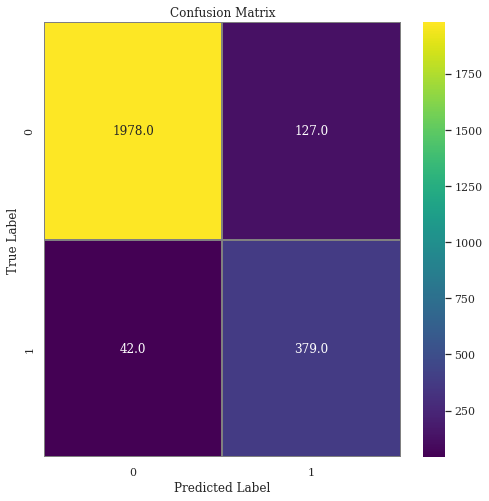

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 1s 24ms/step
Accuracy: 0.9485294117647058
Precision: 0.9632352941176471
F1-score: 0.861842105263158
ROC-curve: 0.9544117647058824
Confusion matrix:


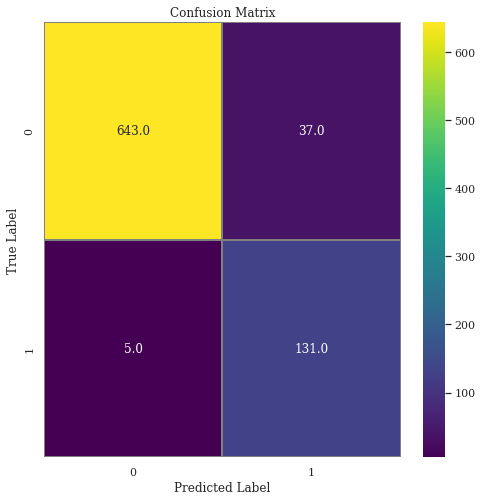

---------------------------------------------------------------------------------------------
-------------------------------------------1----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 1s 15ms/step
Accuracy: 0.9647664291369754
Precision: 0.9572446555819477
F1-score: 0.900558659217877
ROC-curve: 0.9617577197149643
Confusion matrix:


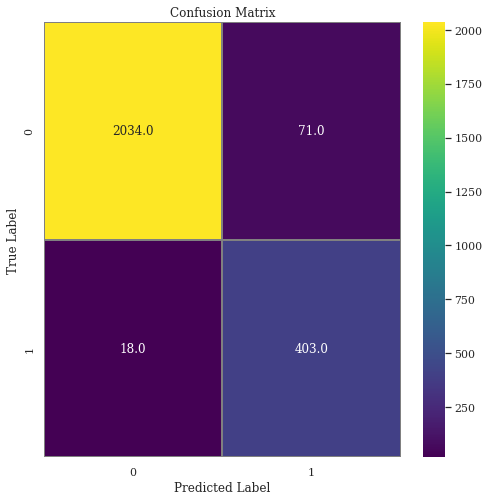

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 0s 14ms/step
Accuracy: 0.9828431372549019
Precision: 0.9926470588235294
F1-score: 0.9507042253521126
ROC-curve: 0.986764705882353
Confusion matrix:


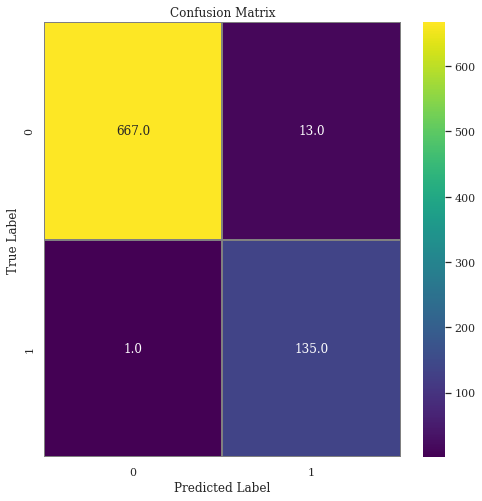

---------------------------------------------------------------------------------------------
-------------------------------------------2----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 1s 15ms/step
Accuracy: 0.9853523357086302
Precision: 0.9904988123515439
F1-score: 0.9575200918484499
ROC-curve: 0.9874109263657956
Confusion matrix:


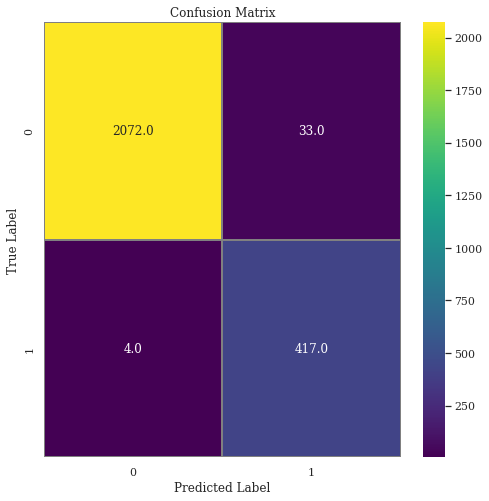

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 0s 15ms/step
Accuracy: 0.9901960784313726
Precision: 1.0
F1-score: 0.9714285714285714
ROC-curve: 0.9941176470588236
Confusion matrix:


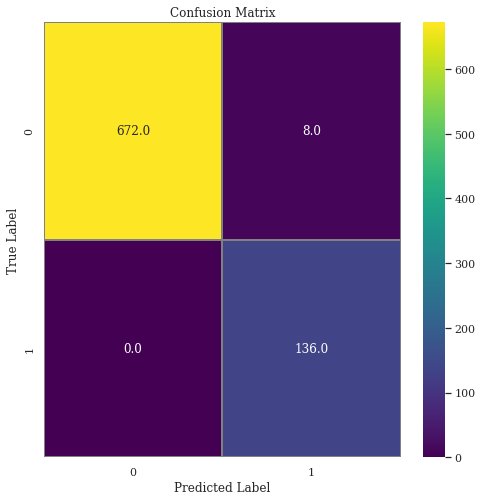

---------------------------------------------------------------------------------------------
-------------------------------------------3----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 1s 15ms/step
Accuracy: 0.9853523357086302
Precision: 0.995249406175772
F1-score: 0.9577142857142857
ROC-curve: 0.9893111638954869
Confusion matrix:


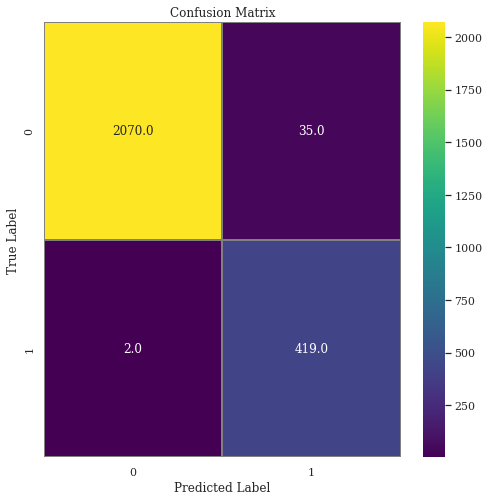

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 0s 16ms/step
Accuracy: 0.991421568627451
Precision: 1.0
F1-score: 0.974910394265233
ROC-curve: 0.9948529411764706
Confusion matrix:


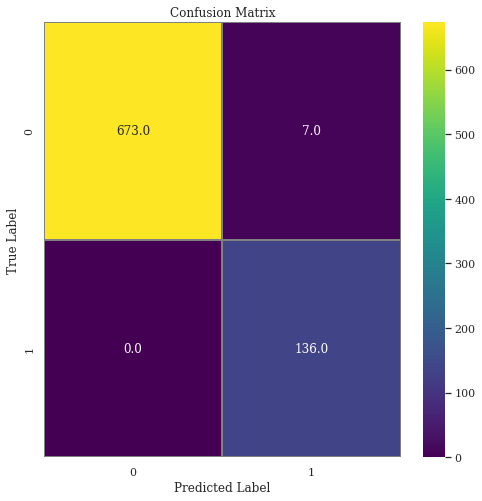

---------------------------------------------------------------------------------------------
-------------------------------------------4----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 1s 15ms/step
Accuracy: 0.994061757719715
Precision: 0.997624703087886
F1-score: 0.9824561403508771
ROC-curve: 0.9954869358669834
Confusion matrix:


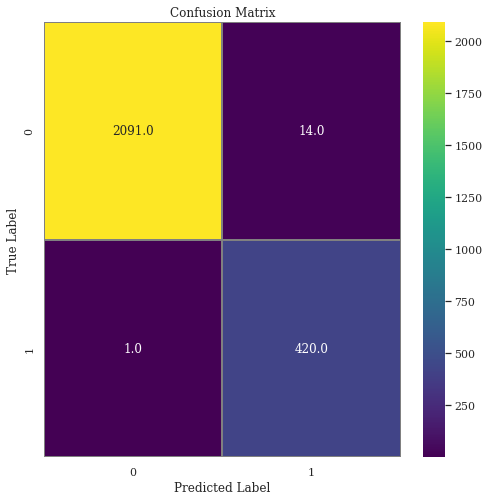

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 1s 25ms/step
Accuracy: 0.9938725490196079
Precision: 1.0
F1-score: 0.9819494584837545
ROC-curve: 0.9963235294117647
Confusion matrix:


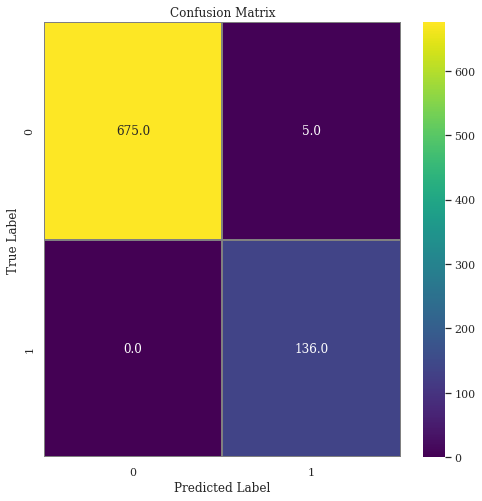

---------------------------------------------------------------------------------------------
-------------------------------------------5----------------------------------------------
-----------------------------------------training--------------------------------------------
79/79 [==============================] - 1s 15ms/step
Accuracy: 0.9956452889944576
Precision: 1.0
F1-score: 0.9871043376318874
ROC-curve: 0.9973871733966746
Confusion matrix:


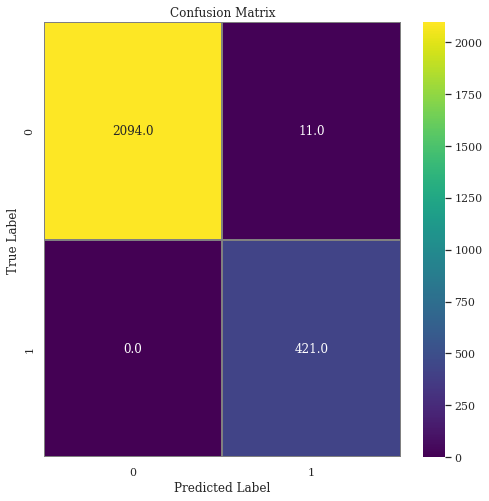

-----------------------------------------testing---------------------------------------------
26/26 [==============================] - 0s 16ms/step
Accuracy: 0.991421568627451
Precision: 1.0
F1-score: 0.974910394265233
ROC-curve: 0.9948529411764706
Confusion matrix:


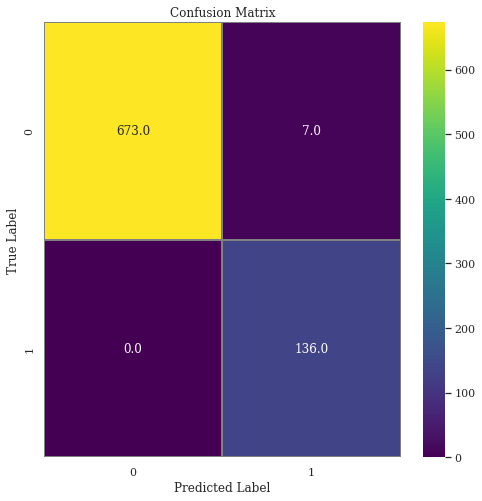

---------------------------------------------------------------------------------------------


In [ ]:
for i in range(6):
  print(f"-------------------------------------------{i}----------------------------------------------")
  eegmodel = load_model(f"/content/EEGNet_checkpoint_{i}.h5")
  print("-----------------------------------------training--------------------------------------------")
  metric(x_train,y_train,eegmodel)
  print("-----------------------------------------testing---------------------------------------------")
  metric(x_test,y_test,eegmodel)
  print("---------------------------------------------------------------------------------------------")

# **ChronoNet**

**V1**

In [ ]:
def chrono_v1():
  # Define the model architecture
  model = Sequential()

  # Add the convolutional layers
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(32, 32)))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

  # Add the max pooling layers
  model.add(MaxPooling1D(pool_size=2, strides=2))

  # Add the recurrent layers
  model.add(LSTM(units=32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
  model.add(LSTM(units=32, dropout=0.5, recurrent_dropout=0.5))

  # Concatenate the output from the convolutional and recurrent layers
  model.add(Flatten())
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units=1, activation='sigmoid'))
  return model

In [ ]:
chrono_v1_model=None
chrono_v1_model = chrono_v1()
K_Fold_Val("chrono_v1", chrono_v1_model, x, y, 25, 8, K=5)

Epoch 1/25
333/334 [============================>.] - ETA: 0s - loss: 0.6679 - accuracy: 0.5353
Epoch 1: val_loss improved from inf to 0.57669, saving model to chrono_v1_checkpoint_0.h5
334/334 [==============================] - 23s 39ms/step - loss: 0.6680 - accuracy: 0.5356 - val_loss: 0.5767 - val_accuracy: 0.6123
Epoch 2/25
333/334 [============================>.] - ETA: 0s - loss: 0.6309 - accuracy: 0.6434
Epoch 2: val_loss did not improve from 0.57669
334/334 [==============================] - 11s 33ms/step - loss: 0.6309 - accuracy: 0.6428 - val_loss: 0.6072 - val_accuracy: 0.6228
Epoch 3/25
334/334 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6574
Epoch 3: val_loss did not improve from 0.57669
334/334 [==============================] - 12s 36ms/step - loss: 0.6036 - accuracy: 0.6574 - val_loss: 0.6363 - val_accuracy: 0.6362
Epoch 4/25
333/334 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.6749
Epoch 4: val_loss did not improve

In [ ]:
chrono_v1_model = load_model("/content/chrono_v1_checkpoint_4.h5")

79/79 [==============================] - 1s 7ms/step
Accuracy: 0.9908946951702297
Precision: 0.997624703087886
F1-score: 0.9733487833140209
ROC-curve: 0.9935866983372922
Confusion matrix:


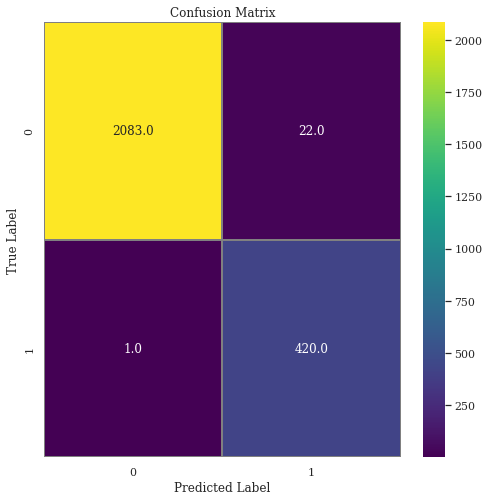

In [ ]:
metric(x_train,y_train,chrono_v1_model)

26/26 [==============================] - 0s 7ms/step
Accuracy: 0.9864197530864197
Precision: 0.9851851851851852
F1-score: 0.9602888086642599
ROC-curve: 0.9859259259259259
Confusion matrix:


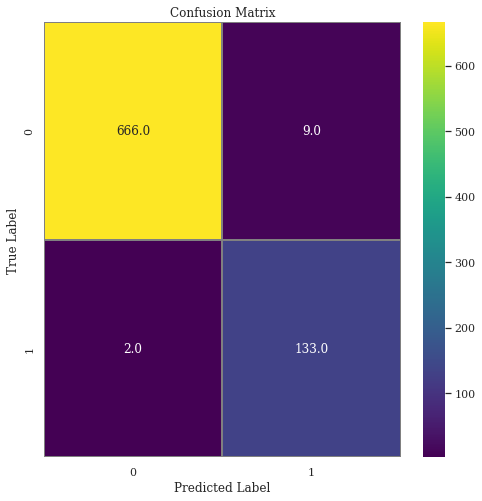

In [ ]:
metric(x_test,y_test,chrono_v1_model)

**V2**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GRU, Dense, Reshape
from tensorflow.keras.models import Model

In [ ]:
def ChronoNet(input_shape=(32, 32, 1)):
  # Input layer
  X_input = Input(input_shape)

  # Convolutional layer
  X = Conv2D(8, (32, 1), strides=(4, 1), padding='same', activation=None)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 1), strides=(2, 1), padding='same')(X)
  X = Dropout(0.5)(X)
  # Reshape output of Convolutional layer to (batch_size, timesteps, input_dim)
  X = Reshape((-1, X.shape[2] * X.shape[3]))(X)

  # Recurrent layer
  X = GRU(16, return_sequences=True)(X)
  X = Dropout(0.5)(X)
  X = GRU(16)(X)
  X = Dropout(0.5)(X)

  # Output layer
  X = Dense(1, activation='sigmoid')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X)

  return model

In [ ]:
chrono_v2_model = None
chrono_v2_model = ChronoNet(input_shape=(32, 32, 1))
K_Fold_Val("chrono_v2", chrono_v2_model, x, y, 20, 8, K=5)

Epoch 1/20
331/334 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.5370
Epoch 1: val_loss improved from inf to 0.64350, saving model to chrono_v2_checkpoint_0.h5
334/334 [==============================] - 21s 19ms/step - loss: 0.7081 - accuracy: 0.5379 - val_loss: 0.6435 - val_accuracy: 0.6527
Epoch 2/20
333/334 [============================>.] - ETA: 0s - loss: 0.6704 - accuracy: 0.5762
Epoch 2: val_loss did not improve from 0.64350
334/334 [==============================] - 5s 15ms/step - loss: 0.6701 - accuracy: 0.5761 - val_loss: 0.6736 - val_accuracy: 0.5838
Epoch 3/20
331/334 [============================>.] - ETA: 0s - loss: 0.6435 - accuracy: 0.6299
Epoch 3: val_loss improved from 0.64350 to 0.60054, saving model to chrono_v2_checkpoint_0.h5
334/334 [==============================] - 4s 13ms/step - loss: 0.6418 - accuracy: 0.6304 - val_loss: 0.6005 - val_accuracy: 0.6647
Epoch 4/20
334/334 [==============================] - ETA: 0s - loss: 0.6231 - accur

In [ ]:
chrono_v2_model = load_model("/content/chrono_v2_checkpoint_3.h5")

79/79 [==============================] - 3s 13ms/step
Accuracy: 0.9699129057798892
Precision: 0.9311163895486936
F1-score: 0.9116279069767441
ROC-curve: 0.9543942992874109
Confusion matrix:


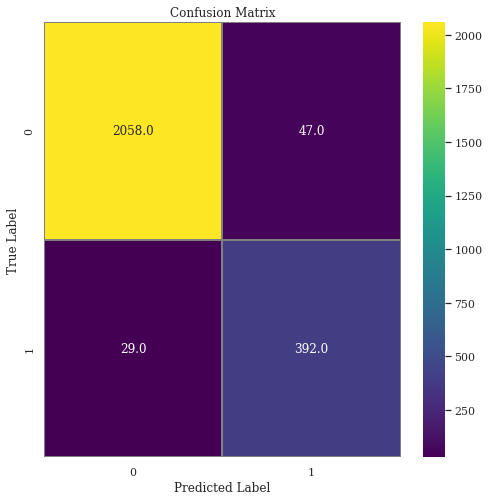

In [ ]:
metric(x_train,y_train,chrono_v2_model)

26/26 [==============================] - 0s 8ms/step
Accuracy: 0.9851851851851852
Precision: 0.9555555555555556
F1-score: 0.9555555555555556
ROC-curve: 0.9733333333333334
Confusion matrix:


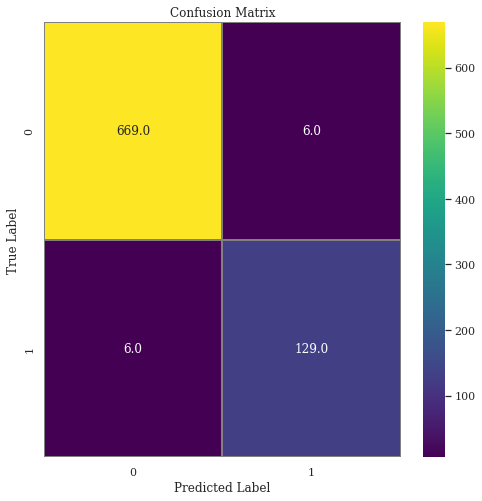

In [ ]:
metric(x_test,y_test,chrono_v2_model)

**V3**

In [ ]:
def ChronoNet(input_shape=(32, None, 1)):
  # Input layer
  X_input = Input(input_shape)

  # Convolutional layer
  X = Conv2D(8, (32, 1), strides=(4, 1), padding='same', activation=None)(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2, 1), strides=(2, 1), padding='same')(X)
  X = Dropout(0.5)(X)

  # Reshape to convert to 3D tensor
  X = Reshape((-1, X.shape[2]*X.shape[3]))(X)

  # Recurrent layer
  X = LSTM(16, return_sequences=True)(X)
  X = Dropout(0.5)(X)
  X = LSTM(16)(X)
  X = Dropout(0.5)(X)

  # Output layer
  X = Dense(1, activation='sigmoid')(X)

  # Create model
  model = Model(inputs=X_input, outputs=X)

  return model

In [ ]:
chrono_v3_model = None
chrono_v3_model = ChronoNet(input_shape=(32, 32, 1))
K_Fold_Val("chrono_v3", chrono_v3_model, x, y, 20, 8, K=5) #32

Epoch 1/20
332/334 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.5693
Epoch 1: val_loss improved from inf to 0.67366, saving model to chrono_v3_checkpoint_0.h5
334/334 [==============================] - 12s 17ms/step - loss: 0.6920 - accuracy: 0.5693 - val_loss: 0.6737 - val_accuracy: 0.5853
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.6600
Epoch 2: val_loss did not improve from 0.67366
334/334 [==============================] - 5s 15ms/step - loss: 0.6449 - accuracy: 0.6600 - val_loss: 0.7427 - val_accuracy: 0.5509
Epoch 3/20
331/334 [============================>.] - ETA: 0s - loss: 0.6090 - accuracy: 0.6847
Epoch 3: val_loss improved from 0.67366 to 0.48702, saving model to chrono_v3_checkpoint_0.h5
334/334 [==============================] - 6s 18ms/step - loss: 0.6103 - accuracy: 0.6833 - val_loss: 0.4870 - val_accuracy: 0.7889
Epoch 4/20
331/334 [============================>.] - ETA: 0s - loss: 0.5596 - accur

In [ ]:
chrono_v3_model = load_model("/content/chrono_v3_checkpoint_4.h5")

79/79 [==============================] - 3s 8ms/step
Accuracy: 0.9647664291369754
Precision: 0.9833729216152018
F1-score: 0.9029443838604144
ROC-curve: 0.972209026128266
Confusion matrix:


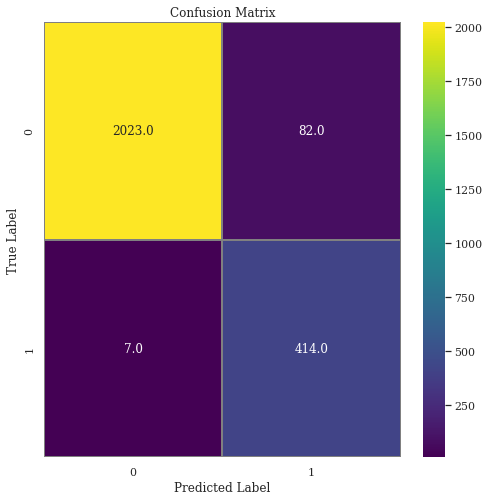

In [ ]:
metric(x_train,y_train,chrono_v3_model)

26/26 [==============================] - 0s 9ms/step
Accuracy: 0.9666666666666667
Precision: 0.9925925925925926
F1-score: 0.9084745762711864
ROC-curve: 0.9770370370370369
Confusion matrix:


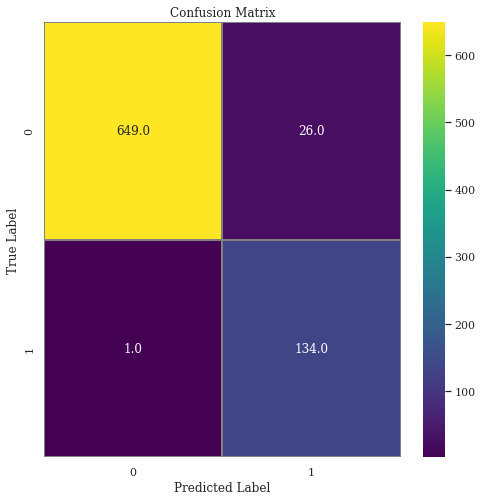

In [ ]:
metric(x_test,y_test,chrono_v3_model)

# **DRCNN**

In [ ]:
#Deep recurrent conv NN
def DRCNN(num_samples=64,num_channels=32,time_steps = 32):

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, num_channels)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
DRCNN_model = None
DRCNN_model = DRCNN(time_steps=32)
K_Fold_Val("DRCNN", DRCNN_model, x, y, 20, 8, K=5) #16

Epoch 1/20
334/334 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.6694
Epoch 1: val_loss improved from inf to 0.64297, saving model to DRCNN_checkpoint_0.h5
334/334 [==============================] - 19s 23ms/step - loss: 0.6813 - accuracy: 0.6694 - val_loss: 0.6430 - val_accuracy: 0.6138
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7256
Epoch 2: val_loss improved from 0.64297 to 0.48253, saving model to DRCNN_checkpoint_0.h5
334/334 [==============================] - 5s 15ms/step - loss: 0.5797 - accuracy: 0.7256 - val_loss: 0.4825 - val_accuracy: 0.7515
Epoch 3/20
331/334 [============================>.] - ETA: 0s - loss: 0.4922 - accuracy: 0.8078
Epoch 3: val_loss did not improve from 0.48253
334/334 [==============================] - 7s 20ms/step - loss: 0.4945 - accuracy: 0.8077 - val_loss: 0.5043 - val_accuracy: 0.7994
Epoch 4/20
332/334 [============================>.] - ETA: 0s - loss: 0.4336 - accuracy: 0.8

In [ ]:
DRCNN_model = load_model("/content/DRCNN_checkpoint_4.h5")

79/79 [==============================] - 2s 6ms/step
Accuracy: 0.9980205859065716
Precision: 1.0
F1-score: 0.9940968122786306
ROC-curve: 0.998812351543943
Confusion matrix:


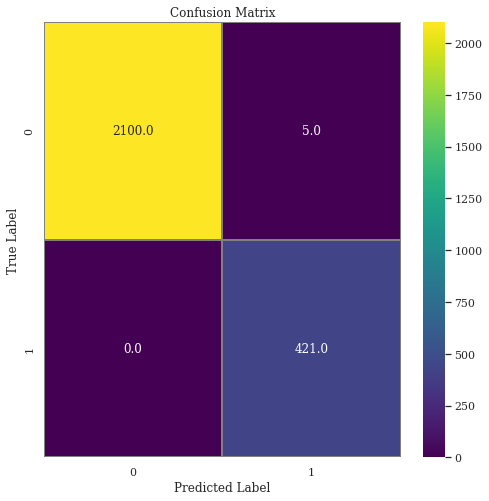

In [ ]:
metric(x_train,y_train,DRCNN_model)

26/26 [==============================] - 0s 9ms/step
Accuracy: 0.9962962962962963
Precision: 0.9925925925925926
F1-score: 0.988929889298893
ROC-curve: 0.9948148148148148
Confusion matrix:


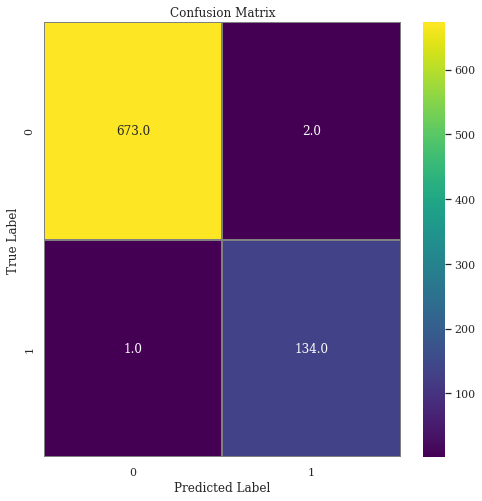

In [ ]:
metric(x_test,y_test,DRCNN_model)

# **CNN**

In [ ]:
def CNN(input_shape=(32, 32, 1)):
  # Define the CNN model
  model = tf.keras.Sequential()

  # Add the convolutional layers
  model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))

  # Add the pooling layers
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  # Add the flatten layer
  model.add(layers.Flatten())

  # Add the fully connected layers
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
CNN_model = None
CNN_model = CNN()
K_Fold_Val("CNN", CNN_model, x, y, 30, 16, K=6)

Epoch 1/30
174/174 [==============================] - ETA: 0s - loss: 0.6050 - accuracy: 0.7187
Epoch 1: val_loss improved from inf to 0.49913, saving model to CNN_checkpoint_0.h5
174/174 [==============================] - 16s 82ms/step - loss: 0.6050 - accuracy: 0.7187 - val_loss: 0.4991 - val_accuracy: 0.7626
Epoch 2/30
174/174 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8385
Epoch 2: val_loss improved from 0.49913 to 0.23546, saving model to CNN_checkpoint_0.h5
174/174 [==============================] - 13s 74ms/step - loss: 0.3610 - accuracy: 0.8385 - val_loss: 0.2355 - val_accuracy: 0.9245
Epoch 3/30
105/174 [=================>............] - ETA: 4s - loss: 0.2760 - accuracy: 0.8845

KeyboardInterrupt: ignored

-------------------------------------------0----------------------------------------------
-----------------------------------------training--------------------------------------------
78/78 [==============================] - 2s 28ms/step
Accuracy: 0.9557165861513688
Precision: 0.8164251207729468
F1-score: 0.8600508905852418
ROC-curve: 0.9
Confusion matrix:


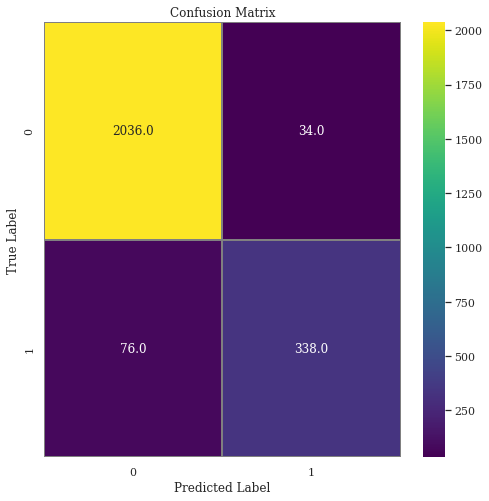

-----------------------------------------testing---------------------------------------------
27/27 [==============================] - 1s 28ms/step
Accuracy: 0.9808153477218226
Precision: 0.9424460431654677
F1-score: 0.9424460431654677
ROC-curve: 0.9654676258992805
Confusion matrix:


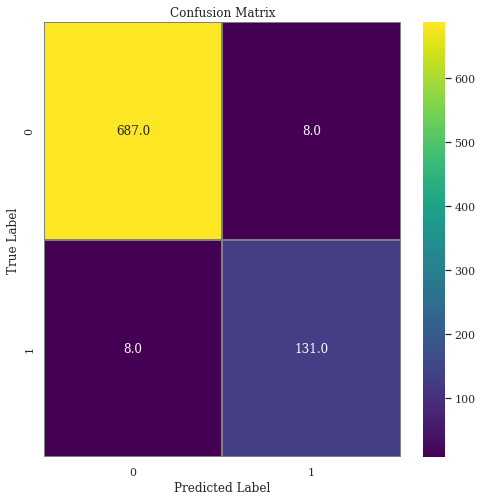

---------------------------------------------------------------------------------------------
-------------------------------------------1----------------------------------------------
-----------------------------------------training--------------------------------------------
78/78 [==============================] - 2s 29ms/step
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0
ROC-curve: 1.0
Confusion matrix:


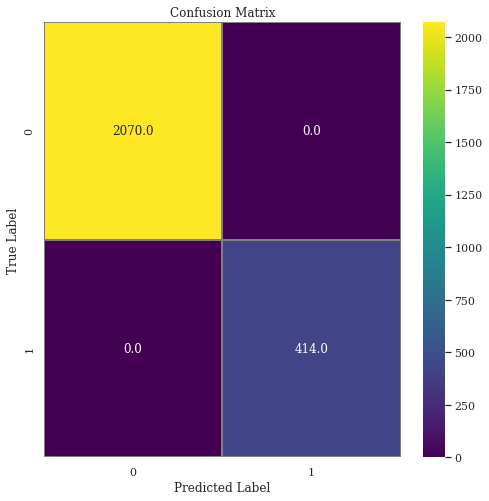

-----------------------------------------testing---------------------------------------------
27/27 [==============================] - 1s 52ms/step
Accuracy: 0.9976019184652278
Precision: 1.0
F1-score: 0.9928571428571429
ROC-curve: 0.9985611510791367
Confusion matrix:


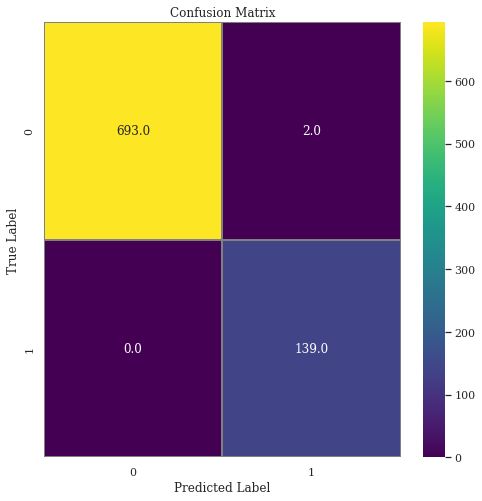

---------------------------------------------------------------------------------------------
-------------------------------------------2----------------------------------------------
-----------------------------------------training--------------------------------------------
78/78 [==============================] - 4s 44ms/step
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0
ROC-curve: 1.0
Confusion matrix:


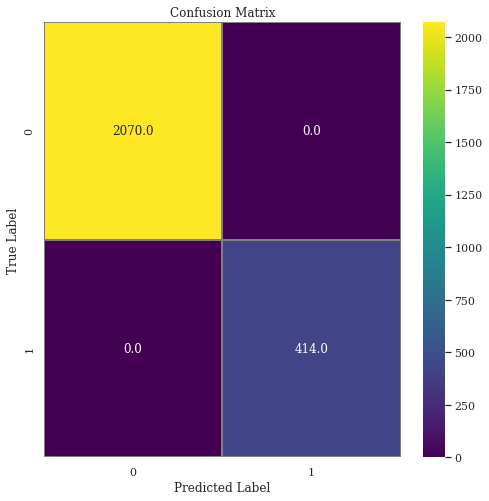

-----------------------------------------testing---------------------------------------------
27/27 [==============================] - 1s 28ms/step
Accuracy: 0.9976019184652278
Precision: 1.0
F1-score: 0.9928571428571429
ROC-curve: 0.9985611510791367
Confusion matrix:


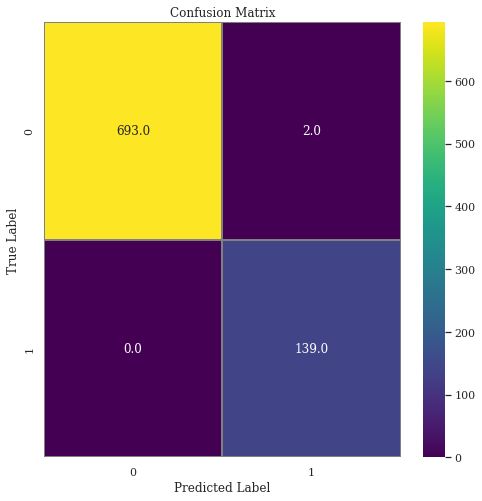

---------------------------------------------------------------------------------------------
-------------------------------------------3----------------------------------------------
-----------------------------------------training--------------------------------------------
78/78 [==============================] - 2s 29ms/step
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0
ROC-curve: 1.0
Confusion matrix:


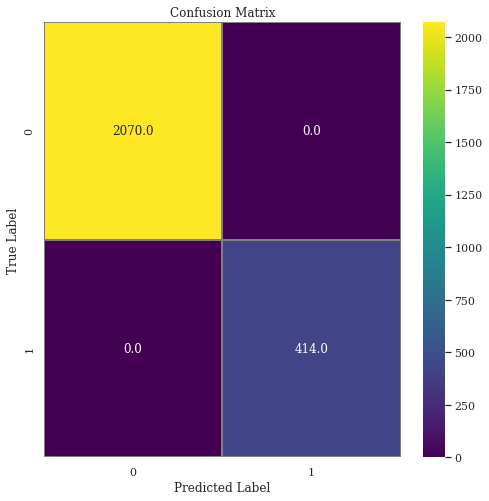

-----------------------------------------testing---------------------------------------------
27/27 [==============================] - 1s 29ms/step
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0
ROC-curve: 1.0
Confusion matrix:


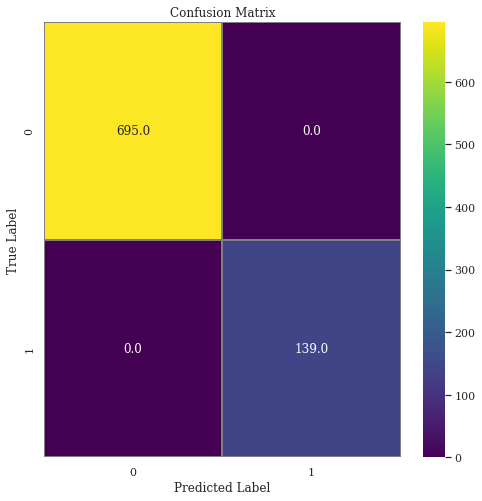

---------------------------------------------------------------------------------------------
-------------------------------------------4----------------------------------------------
-----------------------------------------training--------------------------------------------
78/78 [==============================] - 3s 41ms/step
Accuracy: 1.0
Precision: 1.0
F1-score: 1.0
ROC-curve: 1.0
Confusion matrix:


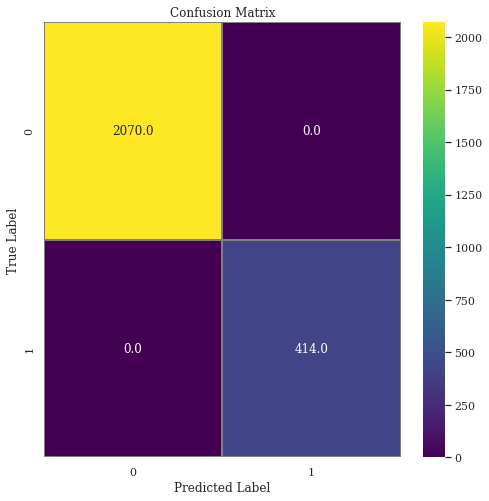

-----------------------------------------testing---------------------------------------------
27/27 [==============================] - 1s 30ms/step
Accuracy: 0.9988009592326139
Precision: 0.9928057553956835
F1-score: 0.996389891696751
ROC-curve: 0.9964028776978417
Confusion matrix:


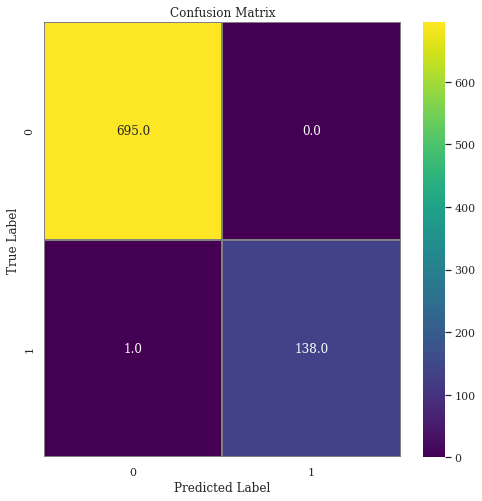

---------------------------------------------------------------------------------------------


In [ ]:
for i in range(5):
  print(f"-------------------------------------------{i}----------------------------------------------")
  eegmodel = load_model(f"/content/CNN_checkpoint_{i}.h5")
  print("-----------------------------------------training--------------------------------------------")
  metric(x_train,y_train,eegmodel)
  print("-----------------------------------------testing---------------------------------------------")
  metric(x_test,y_test,eegmodel)
  print("---------------------------------------------------------------------------------------------")